# Categorical Feature Encoding Challenge

In this project we are given a dataset that contains only categorical features, and includes:

 * binary features
 * low- and high-cardinality nominal features
 * low- and high-cardinality ordinal features
 * (potentially) cyclical features

Our goal is to predict a binary target value, so we need to train a binary classifier. The evaluation metric is the area under the ROC curve between the predicted probability and the observed target.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

### First look on the data

In [2]:
train_raw = pd.read_csv("data/train.csv")
test_raw = pd.read_csv('data/test.csv')

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
display_all(train_raw.head())

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


From this first look on our training set we can see that it consists of:
 * the id feature,
 * 5 binary features,
 * 10 nominal features,
 * 6 ordinal features, 
 * 2 cyclical features, and
 * the target value.
 
Let's now check if there are any missing values:

In [4]:
train_raw.isnull().sum()

id        0
bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

As we can see there are no missing values in our training set.

##### The target value

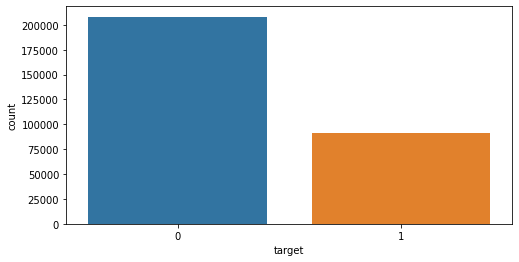

In [5]:
plt.figure(figsize=(8,4))
sns.countplot(x="target", data=train_raw);

We see that the target is skewed and thus it makes sense that the evaluation metric for this Kaggle challenge is the area under the ROC curve.

### Binary features

In [6]:
binary = ['bin_'+str(x) for x in range(5)]
train_raw[binary].head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0,0,0,T,Y
1,0,1,0,T,Y
2,0,0,0,F,Y
3,0,1,0,F,Y
4,0,0,0,F,N


We can see from the above table that features bin_0, bin_1, and bin_2 do not need any transformation. However, features bin_3 and bin_4 need to be transformed into numerical:

In [7]:
train = train_raw.copy()
test = test_raw.copy()

In [8]:
for s in (train, test):
    s['bin_3'] = s['bin_3'].map({'T': 1, 'F': 0})
    s['bin_4'] = s['bin_4'].map({'Y': 1, 'N': 0})

In [9]:
train[binary].head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0,0,0,1,1
1,0,1,0,1,1
2,0,0,0,0,1
3,0,1,0,0,1
4,0,0,0,0,0


Everything looks good regarding the binary features! Let's move on to the nominal features.

### Nominal features

In [10]:
nominal = ['nom_'+str(x) for x in range(10)]
train[nominal].head()

,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9
0,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51
1,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21
2,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0
3,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71
4,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7


In [11]:
for feature in nominal:
    print("Unique values in {}: {}".format(feature, train[feature].nunique()))

Unique values in nom_0: 3
Unique values in nom_1: 6
Unique values in nom_2: 6
Unique values in nom_3: 6
Unique values in nom_4: 4
Unique values in nom_5: 222
Unique values in nom_6: 522
Unique values in nom_7: 1220
Unique values in nom_8: 2215
Unique values in nom_9: 11981


The first 5 nominal features (nom_0 to nom_4) have only a few unique values and therefore one-hot encoding would be the proper strategy to handle them.

##### nom_0 to nom_4

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
first_nominals = ['nom_'+str(x) for x in range(5)]

for feat in first_nominals:
    enc = OneHotEncoder(handle_unknown='ignore')
    
    train_1hot = enc.fit_transform(train[feat].values.reshape(-1, 1)).toarray()
    test_1hot = enc.transform(test_raw[feat].values.reshape(-1, 1)).toarray()
    
    columns = enc.categories_
    
    train = train.join(pd.DataFrame(train_1hot, columns=columns, index=train.index))
    test = test.join(pd.DataFrame(test_1hot, columns=columns, index=test.index))

In [14]:
display_all(train.head())

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,"(Blue,)","(Green,)","(Red,)","(Circle,)","(Polygon,)","(Square,)","(Star,)","(Trapezoid,)","(Triangle,)","(Axolotl,)","(Cat,)","(Dog,)","(Hamster,)","(Lion,)","(Snake,)","(Canada,)","(China,)","(Costa Rica,)","(Finland,)","(India,)","(Russia,)","(Bassoon,)","(Oboe,)","(Piano,)","(Theremin,)"
0,0,0,0,0,1,1,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,1,0,1,1,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2,0,0,0,0,1,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3,0,1,0,0,1,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0,0,0,0,0,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


The names of the new columns, as we can see, are tuples so we need to rename these new columns.

In [15]:
new_names = {}
for col in train.columns:
    if type(col) == tuple:
        new_names[col] = col[0]
        
for s in (train, test):
    s.rename(columns=new_names, inplace=True)

We can also delete the original columns:

In [16]:
for s in (train, test):
    s.drop(first_nominals, axis=1, inplace=True)

In [17]:
display_all(train.head())

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,Blue,Green,Red,Circle,Polygon,Square,Star,Trapezoid,Triangle,Axolotl,Cat,Dog,Hamster,Lion,Snake,Canada,China,Costa Rica,Finland,India,Russia,Bassoon,Oboe,Piano,Theremin
0,0,0,0,0,1,1,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,1,0,1,1,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2,0,0,0,0,1,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3,0,1,0,0,1,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0,0,0,0,0,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### nom_5 to nom_9

The values in these columns seems to be hexadecimal. So, a first step would be to transform them to decimal:

In [18]:
for i in range(5,10):
    for s in (train, test):
        s['nom_'+str(i)] = s['nom_'+str(i)].apply(lambda x: int(x, 16))

In [19]:
train[nominal[5:]].head()

,nom_5,nom_6,nom_7,nom_8,nom_9
0,21727636431,15772387348,28175946729,52488569003,12696894801
1,48239551952,67590492097,15952860690,20628767313,66635263009
2,13526359269,2452503736,44731659559,59756902020,46816824784
3,64728884626,21700990058,63461013227,20097444713,35015036273
4,24443727061,8557928957,1306182334,54563352949,47618683559


Let's also use a StandardScaler on these features:

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
second_nominal = ['nom_'+str(x) for x in range(5, 10)]
standardized_names = ['nom_'+str(x)+'_standardized' for x in range(5, 10)]

scaler = StandardScaler()

In [22]:
train_standardized = pd.DataFrame(scaler.fit_transform(train[second_nominal]),
                                                      index=train.index, columns=standardized_names)
test_standardized = pd.DataFrame(scaler.transform(test[second_nominal]),
                                                      index=test.index, columns=standardized_names)

In [23]:
train = train.join(train_standardized)
test = test.join(test_standardized)

And, now let's drop the original nom_5 to nom_9:

In [24]:
for s in (train, test):
    s.drop(second_nominal, axis=1, inplace=True)

In [25]:
display_all(train.head())

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,Blue,Green,Red,Circle,Polygon,Square,Star,Trapezoid,Triangle,Axolotl,Cat,Dog,Hamster,Lion,Snake,Canada,China,Costa Rica,Finland,India,Russia,Bassoon,Oboe,Piano,Theremin,nom_5_standardized,nom_6_standardized,nom_7_standardized,nom_8_standardized,nom_9_standardized
0,0,0,0,0,1,1,2,Grandmaster,Cold,h,D,kr,2,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.569918,-0.955853,-0.359670,0.909183,-1.091592
1,1,0,1,0,1,1,1,Grandmaster,Hot,a,A,bF,7,8,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.745177,1.608592,-0.966683,-0.694389,1.624986
2,2,0,0,0,0,1,1,Expert,Lava Hot,h,R,Jc,7,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.976734,-1.615045,0.462506,1.275014,0.626840
3,3,0,1,0,0,1,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.563112,-0.662450,1.392628,-0.721132,0.032449
4,4,0,0,0,0,0,1,Grandmaster,Freezing,a,R,qP,7,8,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.435190,-1.312892,-1.694055,1.013611,0.667225


### Ordinal features

In [26]:
ordinal = ['ord_'+str(x) for x in range(6)]
train[ordinal].head()

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
0,2,Grandmaster,Cold,h,D,kr
1,1,Grandmaster,Hot,a,A,bF
2,1,Expert,Lava Hot,h,R,Jc
3,1,Grandmaster,Boiling Hot,i,D,kW
4,1,Grandmaster,Freezing,a,R,qP


In [27]:
for feature in ordinal:
    print("Unique values in {}: {}".format(feature, train[feature].nunique()))

Unique values in ord_0: 3
Unique values in ord_1: 5
Unique values in ord_2: 6
Unique values in ord_3: 15
Unique values in ord_4: 26
Unique values in ord_5: 192


In [28]:
train[ordinal].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ord_0   300000 non-null  int64 
 1   ord_1   300000 non-null  object
 2   ord_2   300000 non-null  object
 3   ord_3   300000 non-null  object
 4   ord_4   300000 non-null  object
 5   ord_5   300000 non-null  object
dtypes: int64(1), object(5)
memory usage: 13.7+ MB


Feature ord_0 is numerical and does not require any transformation. The rest of the ordinal features, however, do need to be transformed. For those we could use again the One Hot encoder, but that way we will lose the information of the order. So we would use mapping as we did for features 'bin_3' and 'bin_4'.

##### ord_1 & ord_2

In [29]:
train['ord_1'].unique()

array(['Grandmaster', 'Expert', 'Novice', 'Contributor', 'Master'],
      dtype=object)

In [30]:
ord_1_mapping = {
    "Novice": 0,
    "Contributor": 1,
    "Expert": 2,
    "Master": 3,
    "Grandmaster": 4
}

In [31]:
for s in (train, test):
    s["ord_1"] = s["ord_1"].map(ord_1_mapping)

In [32]:
train['ord_2'].unique()

array(['Cold', 'Hot', 'Lava Hot', 'Boiling Hot', 'Freezing', 'Warm'],
      dtype=object)

In [33]:
ord_2_mapping = {
    "Freezing": 0,
    "Cold": 1,
    "Warm": 2,
    "Hot": 3,
    "Boiling Hot": 4,
    "Lava Hot": 5
}

In [34]:
for s in (train, test):
    s["ord_2"] = s["ord_2"].map(ord_2_mapping)

##### ord_3 to ord_5

In [35]:
for i in range(3, 6):
    mapping = {}
    for index, element in enumerate(sorted(train['ord_'+str(i)].unique().tolist())):
        mapping[element] = index
    for s in (train, test):
        s['ord_'+str(i)] = s['ord_'+str(i)].map(mapping)

In [36]:
train[ordinal].head()

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
0,2,4,1,7,3,136
1,1,4,3,0,0,93
2,1,2,5,7,17,31
3,1,4,4,8,3,134
4,1,4,0,0,17,158


Our data after the transformations:

In [37]:
display_all(train.head())

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,Blue,Green,Red,Circle,Polygon,Square,Star,Trapezoid,Triangle,Axolotl,Cat,Dog,Hamster,Lion,Snake,Canada,China,Costa Rica,Finland,India,Russia,Bassoon,Oboe,Piano,Theremin,nom_5_standardized,nom_6_standardized,nom_7_standardized,nom_8_standardized,nom_9_standardized
0,0,0,0,0,1,1,2,4,1,7,3,136,2,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.569918,-0.955853,-0.359670,0.909183,-1.091592
1,1,0,1,0,1,1,1,4,3,0,0,93,7,8,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.745177,1.608592,-0.966683,-0.694389,1.624986
2,2,0,0,0,0,1,1,2,5,7,17,31,7,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.976734,-1.615045,0.462506,1.275014,0.626840
3,3,0,1,0,0,1,1,4,4,8,3,134,2,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.563112,-0.662450,1.392628,-0.721132,0.032449
4,4,0,0,0,0,0,1,4,0,0,17,158,7,8,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.435190,-1.312892,-1.694055,1.013611,0.667225


Since all of our features are now numeric, we can move on to training our models. We will start with random forest, which is always a good candidate.

### Random Forest

In [38]:
ordinal_labeled = ['ord_'+ str(i) for i in range(6)]
cyclic_labeled = ['day', 'month']
nominal_standardized = ['nom_'+ str(i) + '_standardized' for i in range(5, 10)]

In [39]:
base_columns = [col for col in train.columns if col not in ordinal_labeled + 
                         cyclic_labeled + nominal_standardized + ['id', 'target']]

In [40]:
labeled_columns = ordinal_labeled + cyclic_labeled

In [41]:
features = base_columns + labeled_columns + nominal_standardized

We will use randomized search to find the best hyperparameters for our random forest model. The hyperparameters that we will optimize are:
 * n_estimators: the number of trees in our model
 * min_sample_leaf: the minimum number of samples required to split an internal node
 * max_features: the number of features to consider when looking for the best split

In [42]:
rf = RandomForestClassifier()
hyperparameters = dict(n_estimators=np.arange(10, 220, 50), min_samples_leaf=[1,3,7,15,25], 
                       max_features=['log2', 'sqrt', 0.5])
grid_search = RandomizedSearchCV(rf, hyperparameters, cv=3, verbose=3, scoring='roc_auc', n_iter=20, n_jobs=4)

In [43]:
grid_search.fit(train[features], train['target'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 10.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 30.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=4,
                   param_distributions={'max_features': ['log2', 'sqrt', 0.5],
                                        'min_samples_leaf': [1, 3, 7, 15, 25],
                                        'n_estimators': array([ 10,  60, 110, 160, 210])},
                   scoring='roc_auc', verbose=3)

In [44]:
grid_search.best_score_

0.7572783697756615

In [45]:
grid_search.best_params_

{'n_estimators': 210, 'min_samples_leaf': 15, 'max_features': 'log2'}

In [46]:
rf_best = grid_search.best_estimator_
rf_best.fit(train[features], train['target'])

RandomForestClassifier(max_features='log2', min_samples_leaf=15,
                       n_estimators=210)

In [47]:
test_id = test['id']

In [48]:
submission_rf = {
    "id": test_id,
    "target": rf_best.predict_proba(test[features])[:,1]
}

submission_rf = pd.DataFrame(submission_rf)
submission_rf.to_csv("submission_rf.csv", index=False)

Our score in the public leaderboard is 0.75917, which is not that bad. However, let's see if we can do better than that by using the xgboost classifier.

Note: notice that the best score of our grid search and the score on kaggle are quite similar. This is the reason why we did not use a validation set.

### XGBoost Classifier

For our xgboost model we will optimize the following hyperparameters:
 * n_estimators: the number of trees in our model
 * max_depth: the maximum tree depth for the base learners
 * subsample: subsample ratio of the training instance
 * colsample_bytree: subsample ratio of columns when constructing each tree
 * min_child_weight: minimum sum of instance weight needed in a child
 * learning_rate: boosting learning rate

In [52]:
xgb = XGBClassifier()
hyperparameters = dict(n_estimators=np.arange(150, 250, 10), max_depth=[6, 7, 8], subsample=[0.7, 0.75, 0.8], 
                       colsample_bytree=[0.1, 0.2], min_child_weight=[18, 19, 20],
                       learning_rate=[0.1])
# Create grid search using 5-fold cross validation
grid_search = RandomizedSearchCV(xgb, hyperparameters, cv=3, verbose=3, scoring='roc_auc', n_jobs=4)
grid_search.fit(train[features], train['target'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  5.4min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=No

In [53]:
grid_search.best_params_

{'subsample': 0.7,
 'n_estimators': 220,
 'min_child_weight': 20,
 'max_depth': 8,
 'learning_rate': 0.1,
 'colsample_bytree': 0.1}

In [54]:
grid_search.best_score_

0.7768083425901021

In [55]:
xgb_best = grid_search.best_estimator_
xgb_best.fit(train[features], train['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=220, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
submission_xgb = {
    "id": test_id,
    "target": xgb_best.predict_proba(test[features])[:,1]
}

submission_xgb = pd.DataFrame(submission_xgb)
submission_xgb.to_csv("submission_xgb.csv", index=False)

Our score in the public leaderboard improved to 0.77844! Let's try again to see if we can improve even more. This time we will use a simple logistic regresion.

### Logistic Regression

Reference: https://www.kaggle.com/peterhurford/why-not-logistic-regression

Logistic regression, in general, performs better with one hot encoded features rather than labeled ones. So, for this model we will use scikit-learn's OneHotEncoder to transform the train_raw and test_raw datasets.

In [57]:
target = train_raw['target']
train_id = train_raw['id']
train_raw.drop(['id', 'target'], axis=1, inplace=True)
test_raw.drop(['id'], axis=1, inplace=True)

In [58]:
display_all(train_raw.head())

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8


In [59]:
enc = OneHotEncoder(handle_unknown='ignore')
# we should be careful to fit only on the training set and not on the test set
enc.fit(train_raw)

OneHotEncoder(handle_unknown='ignore')

In [60]:
train_sparse = enc.transform(train_raw)
test_sparse = enc.transform(test_raw)

Having transformed the datasets into sparse one-hot encoded matrices, we can now use Logistic Regression.

In [61]:
lr = LogisticRegression(C=0.1)
print(cross_val_score(lr, train_sparse, target, cv=3, scoring='roc_auc', verbose=3, n_jobs=4))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    4.8s finished


[0.79975429 0.80440827 0.80179542]


In [62]:
lr.fit(train_sparse, target)

LogisticRegression(C=0.1)

In [63]:
submission_lr = {
    "id": test_id,
    "target": lr.predict_proba(test_sparse)[:,1]
}

submission_lr = pd.DataFrame(submission_lr)
submission_lr.to_csv("submission_lr.csv", index=False)

The public leaderboard score now improves to  0.80771, which leads us to the first 32%.

### Averaging

We even try to average the predictions of the previously trained models, but as we can see the results did not improve the score more than the one we achieved with the logistic regression and the one-hot encoded features. 

In [64]:
lr_pred_probs = lr.predict_proba(test_sparse)[:, 1]
xgb_pred_probs = xgb_best.predict_proba(test[features])[:,1]
rf_pred_probs = rf_best.predict_proba(test[features])[:,1]

#### 1. Average the three models

In [65]:
all_three = pd.DataFrame({'id': test_id, 'lr_predictions': lr_pred_probs, 
                          'xgb_predictions': xgb_pred_probs, 'rf_predictions': rf_pred_probs,
                         'average_predictions': (lr_pred_probs + xgb_pred_probs + rf_pred_probs) / 3.},
                         columns=['id', 'lr_predictions', 'xgb_predictions', 'rf_predictions', 'average_predictions'])
all_three.head()

,id,lr_predictions,xgb_predictions,rf_predictions,average_predictions
0,300000,0.352222,0.270701,0.274351,0.299091
1,300001,0.679388,0.536277,0.463158,0.559608
2,300002,0.123644,0.220303,0.238913,0.194287
3,300003,0.434803,0.452545,0.368959,0.418769
4,300004,0.864782,0.754303,0.676404,0.765163


In [66]:
submission_all_three = {
    "id": test_id,
    "target": all_three['average_predictions']
}

submission_all_three = pd.DataFrame(submission_all_three)
submission_all_three.to_csv("submission_all_three.csv", index=False)

Public: 0.79659

#### 2. Average the best two (lr and xgb)

In [67]:
best_two = pd.DataFrame({'id': test_id, 'lr_predictions': lr_pred_probs, 'xgb_predictions': xgb_pred_probs,
                         'average_predictions': (lr_pred_probs + xgb_pred_probs) / 2.},
                         columns=['id', 'lr_predictions', 'xgb_predictions', 'average_predictions'])
best_two.head()

,id,lr_predictions,xgb_predictions,average_predictions
0,300000,0.352222,0.270701,0.311462
1,300001,0.679388,0.536277,0.607833
2,300002,0.123644,0.220303,0.171973
3,300003,0.434803,0.452545,0.443674
4,300004,0.864782,0.754303,0.809543


In [68]:
submission_best_two = {
    "id": test_id,
    "target": best_two['average_predictions']
}

submission_best_two = pd.DataFrame(submission_best_two)
submission_best_two.to_csv("submission_best_two.csv", index=False)

Public: 0.80208